#### Imports & Downloads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score

from src.functions.vectorize_functions import vectorize_tfidf, vectorize_glove, vectorize_w2v

### Model Preparation

#### Functions

In [2]:
def print_target_distribution(df, colname):
    positive = np.count_nonzero(df[colname] == 1)
    negative = np.count_nonzero(df[colname] == 0)
    print("- Positive:", positive)
    print("- Negative:", negative)
    print("- Verhältnis:", negative / positive)

In [3]:
evaluation = pd.DataFrame(
    columns=["model", "tuning", "vec_variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc",
             "test_prec",
             "test_rec", "test_f1"])

In [4]:
def add_to_eval_df(model, model_name, tuning, vec_variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, tuning, vec_variant, train_acc, train_precision, train_recall,
                                             train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [5]:
def evaluate_model(model, x_test, y_test):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### Data Import

In [6]:
df_train_cleaned = pd.read_csv("..\\..\\..\\data\\mixed_dataset\\train_cleaned_rnn.csv")

In [7]:
print_target_distribution(df_train_cleaned, 'label')

- Positive: 14939
- Negative: 68367
- Verhältnis: 4.576410736997121


In [8]:
df_train_cleaned = df_train_cleaned[df_train_cleaned.tweet_cleaned.notna()]
df_train_cleaned.isna().sum()

Unnamed: 0           0
label                0
tweet                0
tweet_cleaned        0
user_handle          0
hashtags             0
emojis           75683
dtype: int64

#### Vectorize - Word2Vec

In [9]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = vectorize_w2v(df=df_train_cleaned,
                                                                 text_column="tweet_cleaned",
                                                                 label_column="label")

#### Vectorize - TF-IDF

In [10]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = vectorize_tfidf(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

#### Vectorize - Glove

In [11]:
X_train_gl, X_test_gl, y_train_gl, y_test_gl = vectorize_glove(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

### Training Functions

In [12]:
def cross_validate_model(model, x_data, y_data, cv=10, scoring='f1'):
    cv = cross_val_score(model, x_data, y_data, cv=cv, scoring=scoring, verbose=10)
    print(f" MEAN: {np.mean(cv)}")

    return cv

#### 1.1 Bagging

##### 1.1.1 RandomForest

In [13]:
def train_randomforest(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [14]:
def train_randomforest_tuned_randsearch(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
    model.fit(x_data, y_data)

    return model

In [15]:
def train_randomforest_tuned_optuna(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, n_estimators=450, max_depth=55, min_samples_split=4, min_samples_leaf=1)
    model.fit(x_data, y_data)

    return model

##### 1.1.2 BalancedRandomForest untuned

In [16]:
def train_balancedrandomforest(x_data, y_data):
    model = BalancedRandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [17]:
# def train_balancedrandomforest_tuned(x_data, y_data):
#     model = BalancedRandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
#     model.fit(x_data, y_data)
#
#     return model

#### 1.2 Boosting

##### 1.2.1 XGBClassifier

In [18]:
def train_xgboost(x_data, y_data):
    model = XGBClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [19]:
def train_xgboost_tuned_gridsearch(x_data, y_data):
    model = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
    model.fit(x_data, y_data)

    return model

In [20]:
def train_xgboost_tuned_randsearch(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, subsample=0.5, reg_alpha=1, n_estimators=150, min_child_weight=1,
                          max_depth=7, learning_rate=0.1, gamma=0.4)
    model.fit(x_data, y_data)

    return model

In [21]:
def train_xgboost_tuned_optuna(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, boost='gblinear', subsample=0.4736419905302216,
                          colsample_bytree=0.6711055768358083, alpha=8.528933855762793e-06)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 CatBoostClassifier

In [22]:
def train_catboost(x_data, y_data):
    model = CatBoostClassifier(iterations=100,
                               depth=5,
                               learning_rate=0.1,
                               loss_function='Logloss',
                               verbose=True)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 LGBMClassifier

In [23]:
def train_lightgbm(x_data, y_data):
    model = LGBMClassifier()
    model.fit(x_data, y_data)

    return model

#### 1.3 Stacking

##### 1.3.1 Stacking: RandomForest + LinearSVC

In [24]:
def train_stacking_rf_svm(x_data, y_data):
    base_models = [
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', LinearSVC(random_state=42))
    ]
    model = StackingClassifier(estimators=base_models, n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [25]:
def train_svc(x_data, y_data):
    model = LinearSVC()
    model.fit(x_data, y_data)

    return model

### Model Training

#### W2V

model accuracy for classification is = 82.55%
------------------------------------------------
Confusion Matrix:
       0    1
0  20256  176
1   4184  376
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     20432
           1       0.68      0.08      0.15      4560

    accuracy                           0.83     24992
   macro avg       0.75      0.54      0.52     24992
weighted avg       0.80      0.83      0.76     24992



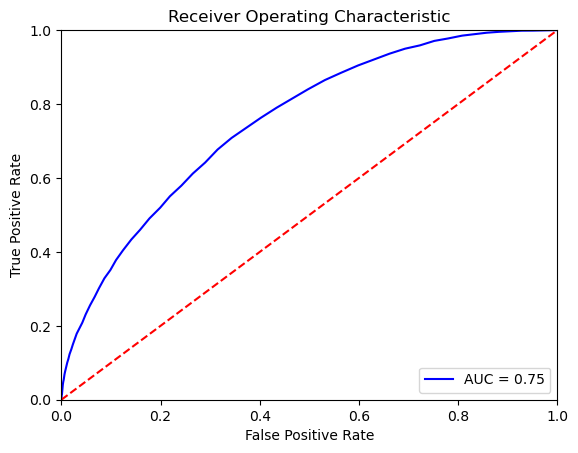

In [26]:
rf_untuned_w2v = train_randomforest(X_train_w2v, y_train_w2v)
evaluate_model(rf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_untuned_w2v, "RandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 81.79%
------------------------------------------------
Confusion Matrix:
       0   1
0  20428   4
1   4548  12
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     20432
           1       0.75      0.00      0.01      4560

    accuracy                           0.82     24992
   macro avg       0.78      0.50      0.45     24992
weighted avg       0.81      0.82      0.74     24992



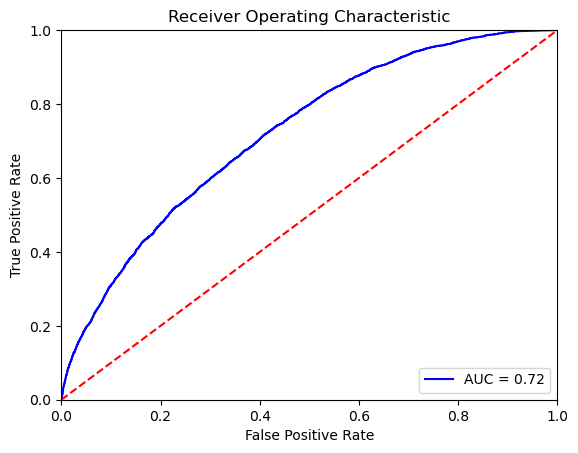

In [27]:
rf_rand_w2v = train_randomforest_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(rf_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_rand_w2v, "RandomForest", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 82.61%
------------------------------------------------
Confusion Matrix:
       0    1
0  20285  147
1   4200  360
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     20432
           1       0.71      0.08      0.14      4560

    accuracy                           0.83     24992
   macro avg       0.77      0.54      0.52     24992
weighted avg       0.81      0.83      0.76     24992



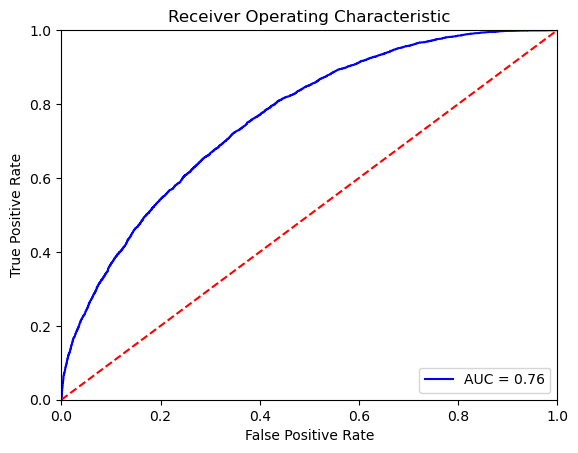

In [28]:
rf_optuna_w2v = train_randomforest_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(rf_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_optuna_w2v, "RandomForest", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 69.07%
------------------------------------------------
Confusion Matrix:
       0     1
0  13887  6545
1   1185  3375
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.68      0.78     20432
           1       0.34      0.74      0.47      4560

    accuracy                           0.69     24992
   macro avg       0.63      0.71      0.62     24992
weighted avg       0.82      0.69      0.72     24992



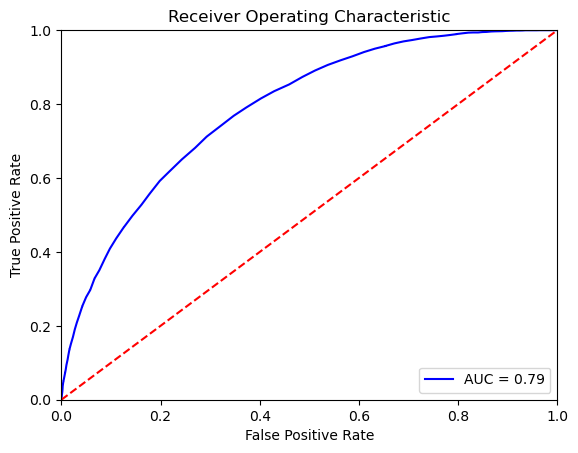

In [29]:
brf_untuned_w2v = train_balancedrandomforest(X_train_w2v, y_train_w2v)
evaluate_model(brf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(brf_untuned_w2v, "BalancedRandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

model accuracy for classification is = 83.18%
------------------------------------------------
Confusion Matrix:
       0     1
0  19654   778
1   3425  1135
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     20432
           1       0.59      0.25      0.35      4560

    accuracy                           0.83     24992
   macro avg       0.72      0.61      0.63     24992
weighted avg       0.80      0.83      0.80     24992



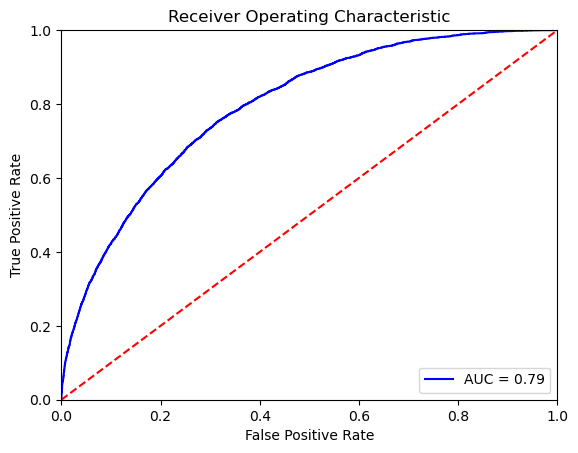

In [30]:
xgb_untuned_w2v = train_xgboost(X_train_w2v, y_train_w2v)
evaluate_model(xgb_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_untuned_w2v, "XGBoost", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 83.81%
------------------------------------------------
Confusion Matrix:
       0    1
0  20003  429
1   3618  942
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     20432
           1       0.69      0.21      0.32      4560

    accuracy                           0.84     24992
   macro avg       0.77      0.59      0.61     24992
weighted avg       0.82      0.84      0.80     24992



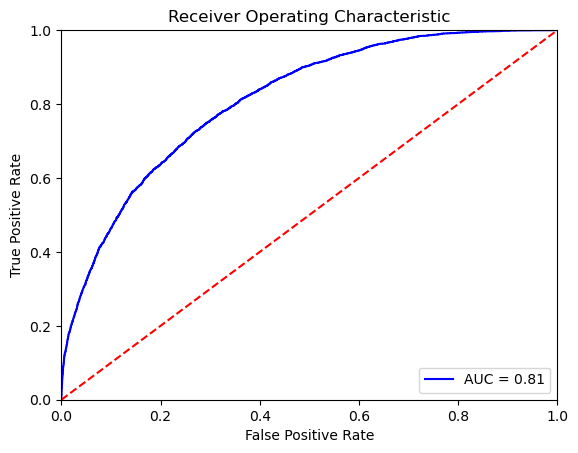

In [31]:
xgb_grid_w2v = train_xgboost_tuned_gridsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_grid_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_grid_w2v, "XGBoost", "gridsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 83.67%
------------------------------------------------
Confusion Matrix:
       0     1
0  19830   602
1   3480  1080
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91     20432
           1       0.64      0.24      0.35      4560

    accuracy                           0.84     24992
   macro avg       0.75      0.60      0.63     24992
weighted avg       0.81      0.84      0.80     24992



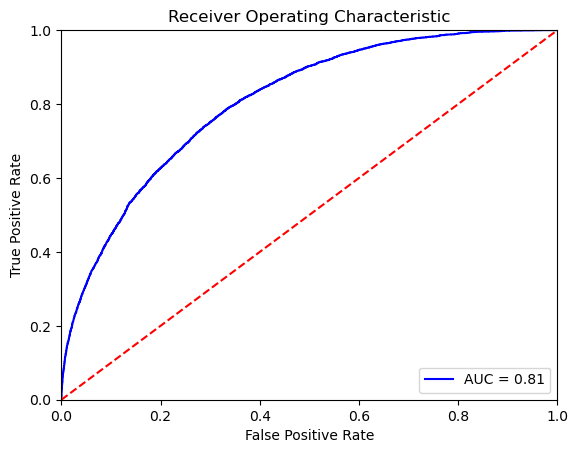

In [32]:
xgb_rand_w2v = train_xgboost_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_rand_w2v, "XGBoost", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:49] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 82.42%
------------------------------------------------
Confusion Matrix:
       0     1
0  19303  1129
1   3265  1295
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     20432
           1       0.53      0.28      0.37      4560

    accuracy                           0.82     24992
   macro avg       0.69      0.61      0.63     24992
weighted avg       0.80      0.82      0.80     24992



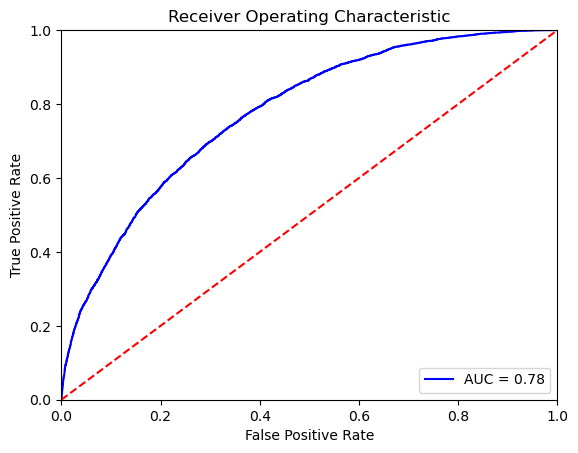

In [33]:
xgb_optuna_w2v = train_xgboost_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(xgb_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_optuna_w2v, "XGBoost", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

0:	learn: 0.6375186	total: 173ms	remaining: 17.1s
1:	learn: 0.5955681	total: 212ms	remaining: 10.4s
2:	learn: 0.5630099	total: 248ms	remaining: 8.02s
3:	learn: 0.5369399	total: 286ms	remaining: 6.86s
4:	learn: 0.5165272	total: 323ms	remaining: 6.14s
5:	learn: 0.4982263	total: 359ms	remaining: 5.62s
6:	learn: 0.4845822	total: 398ms	remaining: 5.28s
7:	learn: 0.4739981	total: 440ms	remaining: 5.05s
8:	learn: 0.4643424	total: 476ms	remaining: 4.82s
9:	learn: 0.4559278	total: 512ms	remaining: 4.61s
10:	learn: 0.4496111	total: 547ms	remaining: 4.42s
11:	learn: 0.4443384	total: 584ms	remaining: 4.28s
12:	learn: 0.4401485	total: 619ms	remaining: 4.14s
13:	learn: 0.4360875	total: 656ms	remaining: 4.03s
14:	learn: 0.4326691	total: 691ms	remaining: 3.92s
15:	learn: 0.4302324	total: 729ms	remaining: 3.83s
16:	learn: 0.4274827	total: 762ms	remaining: 3.72s
17:	learn: 0.4252192	total: 802ms	remaining: 3.65s
18:	learn: 0.4231753	total: 838ms	remaining: 3.57s
19:	learn: 0.4212750	total: 874ms	remaini

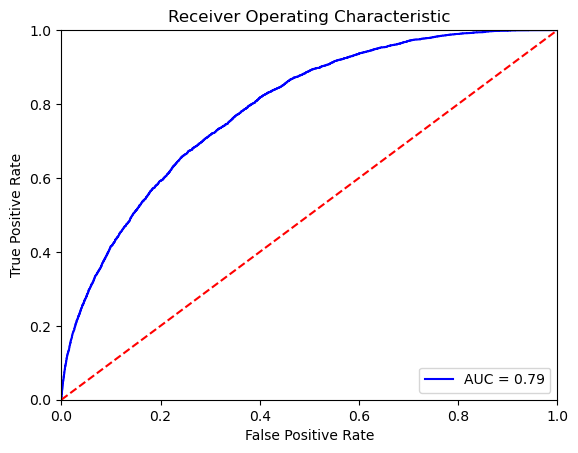

In [34]:
cat_untuned_w2v = train_catboost(X_train_w2v, y_train_w2v)
evaluate_model(cat_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(cat_untuned_w2v, "CatBoostClassifier", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

[LightGBM] [Info] Number of positive: 10379, number of negative: 47934
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 58313, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177988 -> initscore=-1.530041
[LightGBM] [Info] Start training from score -1.530041
model accuracy for classification is = 83.63%
------------------------------------------------
Confusion Matrix:
       0    1
0  20007  425
1   3667  893
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     20432
           1       0.68      0.20      0.30      4560

    accuracy                           0.84     24992
   macro avg       0.76      0.59      0.61     24992
weigh

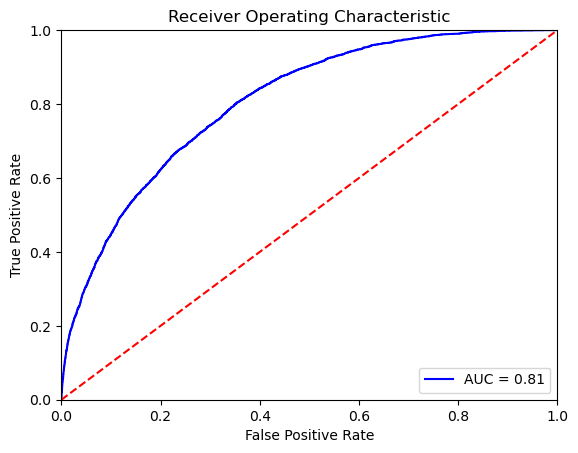

In [35]:
light_untuned_w2v = train_lightgbm(X_train_w2v, y_train_w2v)
evaluate_model(light_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(light_untuned_w2v, "LightGBM", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 83.23%
------------------------------------------------
Confusion Matrix:
       0    1
0  19878  554
1   3637  923
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90     20432
           1       0.62      0.20      0.31      4560

    accuracy                           0.83     24992
   macro avg       0.74      0.59      0.61     24992
weighted avg       0.81      0.83      0.80     24992



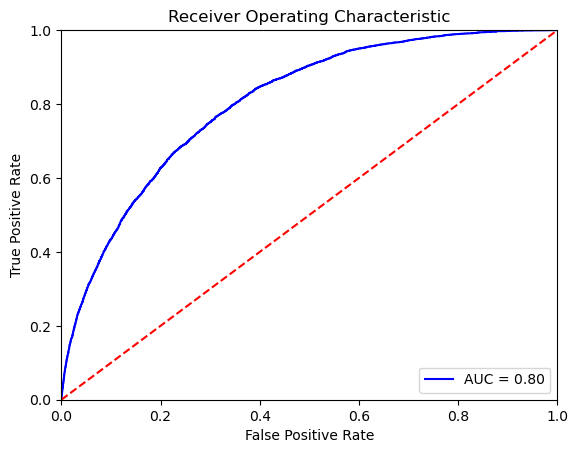

In [36]:
stack_untuned_w2v = train_stacking_rf_svm(X_train_w2v, y_train_w2v)
evaluate_model(stack_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(stack_untuned_w2v, "StackingClassifier-RF-SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

In [37]:
svc_untuned_w2v = train_svc(X_train_w2v, y_train_w2v)
add_to_eval_df(svc_untuned_w2v, "SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### TF-IDF

model accuracy for classification is = 83.84%
------------------------------------------------
Confusion Matrix:
       0    1
0  20119  313
1   3725  835
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     20432
           1       0.73      0.18      0.29      4560

    accuracy                           0.84     24992
   macro avg       0.79      0.58      0.60     24992
weighted avg       0.82      0.84      0.80     24992



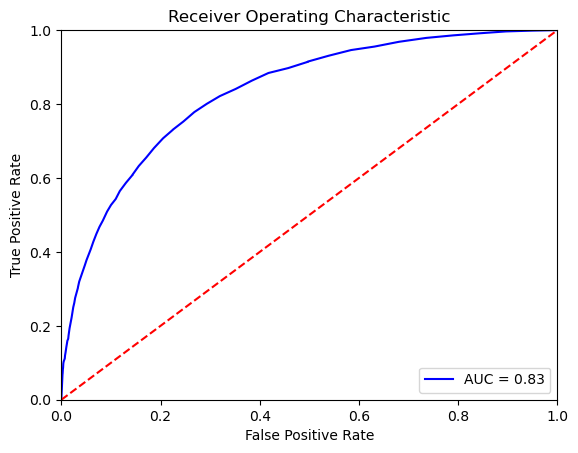

In [38]:
rf_untuned_tf = train_randomforest(X_train_tf, y_train_tf)
evaluate_model(rf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_untuned_tf, "RandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 83.54%
------------------------------------------------
Confusion Matrix:
       0    1
0  20077  355
1   3759  801
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     20432
           1       0.69      0.18      0.28      4560

    accuracy                           0.84     24992
   macro avg       0.77      0.58      0.59     24992
weighted avg       0.82      0.84      0.79     24992



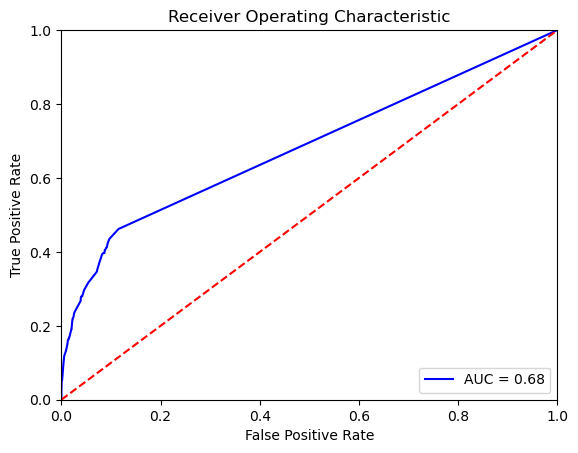

In [39]:
rf_rand_tf = train_randomforest_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(rf_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_rand_tf, "RandomForest", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 81.82%
------------------------------------------------
Confusion Matrix:
       0   1
0  20430   2
1   4541  19
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     20432
           1       0.90      0.00      0.01      4560

    accuracy                           0.82     24992
   macro avg       0.86      0.50      0.45     24992
weighted avg       0.83      0.82      0.74     24992



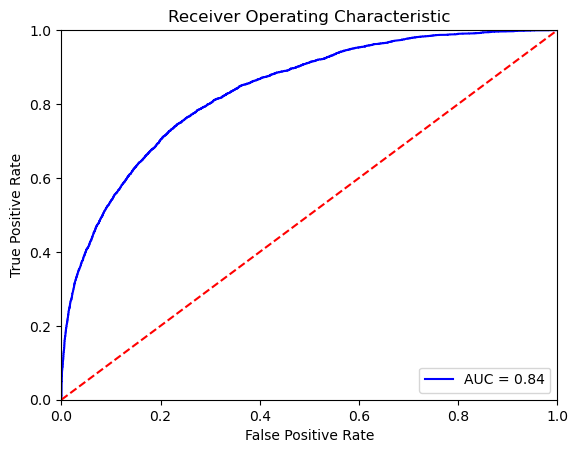

In [40]:
rf_optuna_tf = train_randomforest_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(rf_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_optuna_tf, "RandomForest", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 73.38%
------------------------------------------------
Confusion Matrix:
       0     1
0  14863  5569
1   1085  3475
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.73      0.82     20432
           1       0.38      0.76      0.51      4560

    accuracy                           0.73     24992
   macro avg       0.66      0.74      0.66     24992
weighted avg       0.83      0.73      0.76     24992



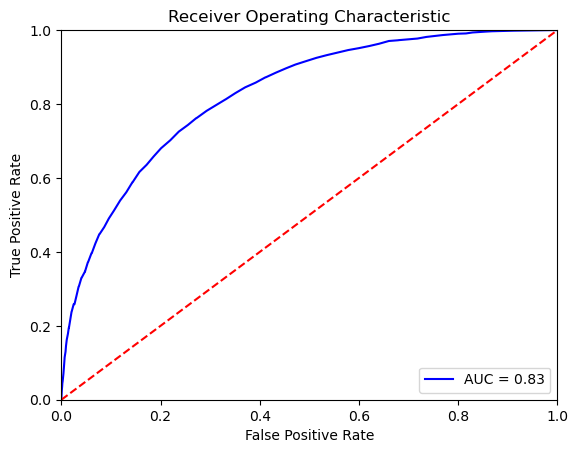

In [41]:
brf_untuned_tf = train_balancedrandomforest(X_train_tf, y_train_tf)
evaluate_model(brf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(brf_untuned_tf, "BalancedRandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 85.34%
------------------------------------------------
Confusion Matrix:
       0     1
0  19959   473
1   3191  1369
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     20432
           1       0.74      0.30      0.43      4560

    accuracy                           0.85     24992
   macro avg       0.80      0.64      0.67     24992
weighted avg       0.84      0.85      0.83     24992



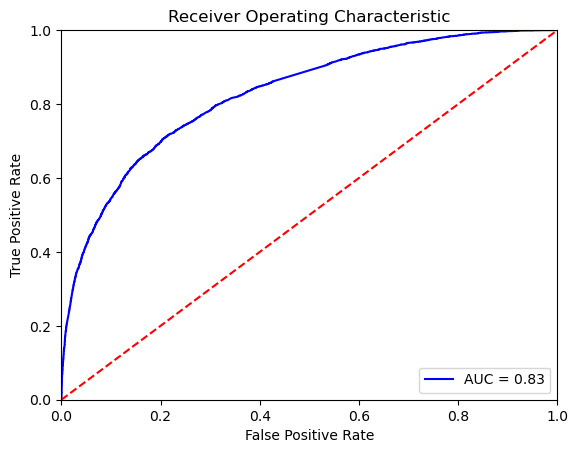

In [42]:
xgb_untuned_tf = train_xgboost(X_train_tf, y_train_tf)
evaluate_model(xgb_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_untuned_tf, "XGBoost", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 85.42%
------------------------------------------------
Confusion Matrix:
       0     1
0  19877   555
1   3088  1472
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     20432
           1       0.73      0.32      0.45      4560

    accuracy                           0.85     24992
   macro avg       0.80      0.65      0.68     24992
weighted avg       0.84      0.85      0.83     24992



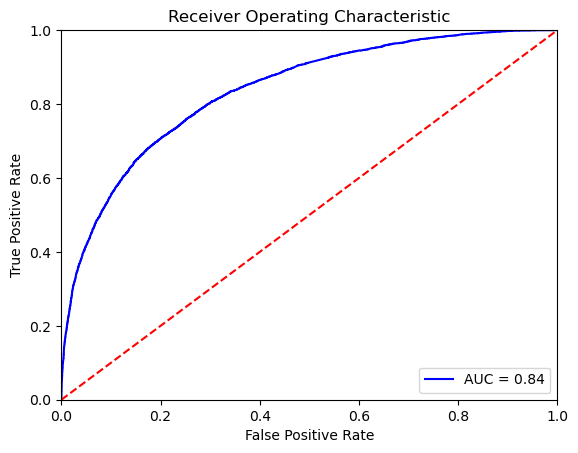

In [43]:
xgb_grid_tf = train_xgboost_tuned_gridsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_grid_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_grid_tf, "XGBoost", "gridsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 85.08%
------------------------------------------------
Confusion Matrix:
       0     1
0  20010   422
1   3307  1253
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     20432
           1       0.75      0.27      0.40      4560

    accuracy                           0.85     24992
   macro avg       0.80      0.63      0.66     24992
weighted avg       0.84      0.85      0.82     24992



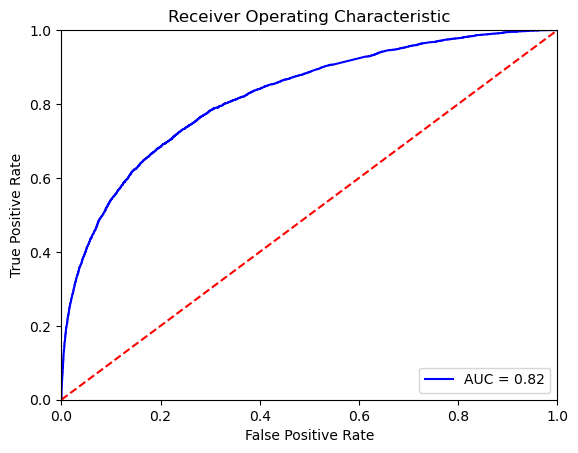

In [44]:
xgb_rand_tf = train_xgboost_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_rand_tf, "XGBoost", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:28] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 84.94%
------------------------------------------------
Confusion Matrix:
       0     1
0  19776   656
1   3109  1451
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     20432
           1       0.69      0.32      0.44      4560

    accuracy                           0.85     24992
   macro avg       0.78      0.64      0.67     24992
weighted avg       0.83      0.85      0.83     24992



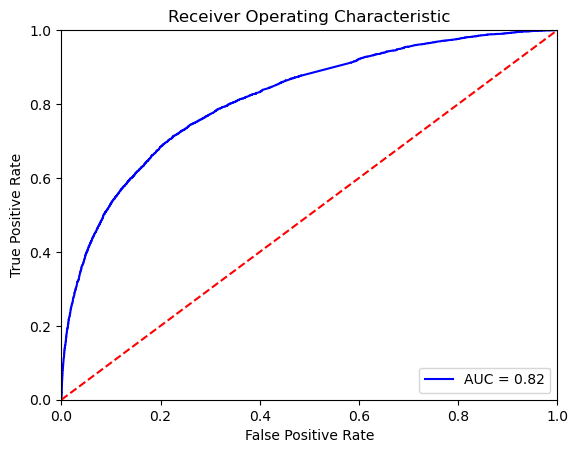

In [45]:
xgb_optuna_tf = train_xgboost_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(xgb_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_optuna_tf, "XGBoost", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

0:	learn: 0.6436347	total: 218ms	remaining: 21.6s
1:	learn: 0.6030193	total: 440ms	remaining: 21.5s
2:	learn: 0.5707196	total: 662ms	remaining: 21.4s
3:	learn: 0.5449441	total: 892ms	remaining: 21.4s
4:	learn: 0.5231799	total: 1.11s	remaining: 21.1s
5:	learn: 0.5066003	total: 1.33s	remaining: 20.9s
6:	learn: 0.4937219	total: 1.56s	remaining: 20.7s
7:	learn: 0.4834332	total: 1.77s	remaining: 20.4s
8:	learn: 0.4743561	total: 1.99s	remaining: 20.1s
9:	learn: 0.4669850	total: 2.21s	remaining: 19.9s
10:	learn: 0.4607227	total: 2.45s	remaining: 19.8s
11:	learn: 0.4548866	total: 2.68s	remaining: 19.7s
12:	learn: 0.4497780	total: 2.92s	remaining: 19.5s
13:	learn: 0.4461664	total: 3.14s	remaining: 19.3s
14:	learn: 0.4426910	total: 3.36s	remaining: 19s
15:	learn: 0.4399652	total: 3.57s	remaining: 18.7s
16:	learn: 0.4373019	total: 3.77s	remaining: 18.4s
17:	learn: 0.4349134	total: 4s	remaining: 18.2s
18:	learn: 0.4327668	total: 4.22s	remaining: 18s
19:	learn: 0.4308811	total: 4.43s	remaining: 17.

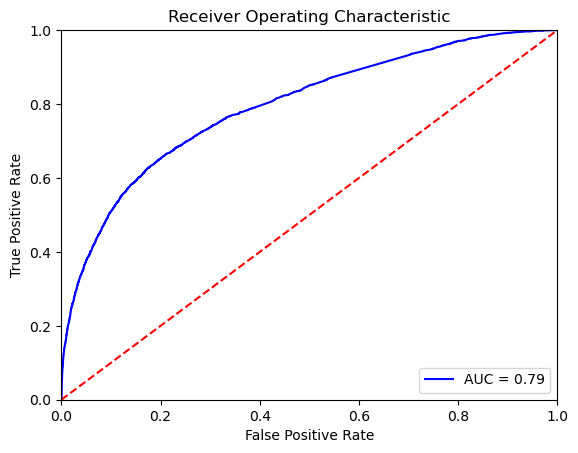

In [46]:
cat_untuned_tf = train_catboost(X_train_tf, y_train_tf)
evaluate_model(cat_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(cat_untuned_tf, "CatBoostClassifier", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

[LightGBM] [Info] Number of positive: 10379, number of negative: 47934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.285661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 162386
[LightGBM] [Info] Number of data points in the train set: 58313, number of used features: 3961
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177988 -> initscore=-1.530041
[LightGBM] [Info] Start training from score -1.530041
model accuracy for classification is = 85.12%
------------------------------------------------
Confusion Matrix:
       0     1
0  19928   504
1   3216  1344
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     20432
           1       0.73      0.29      0.42      4560

    accuracy                           0.85 

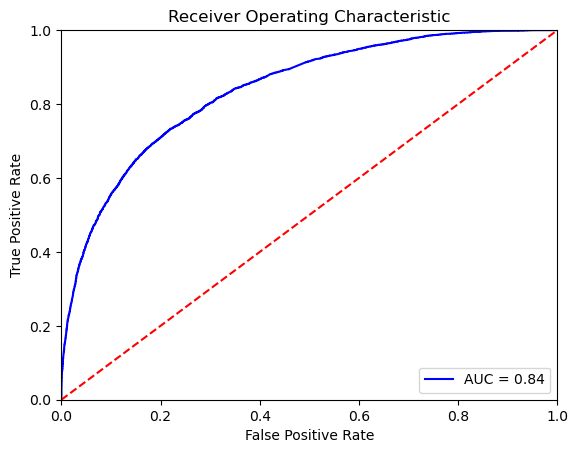

In [47]:
light_untuned_tf = train_lightgbm(X_train_tf, y_train_tf)
evaluate_model(light_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(light_untuned_tf, "LightGBM", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 85.24%
------------------------------------------------
Confusion Matrix:
       0     1
0  19692   740
1   2950  1610
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     20432
           1       0.69      0.35      0.47      4560

    accuracy                           0.85     24992
   macro avg       0.78      0.66      0.69     24992
weighted avg       0.84      0.85      0.83     24992



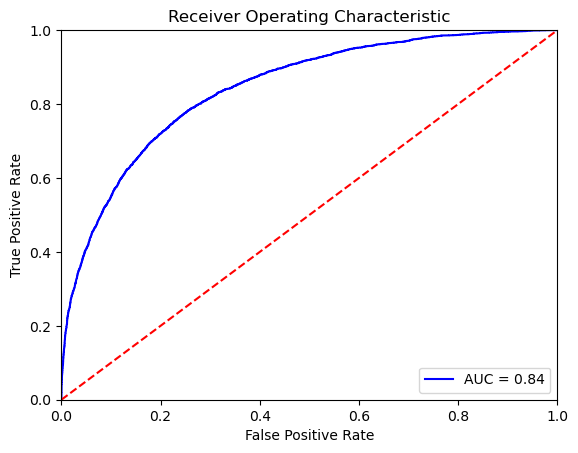

In [48]:
stack_untuned_tf = train_stacking_rf_svm(X_train_tf, y_train_tf)
evaluate_model(stack_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(stack_untuned_tf, "StackingClassifier-RF-SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf,
               y_test_tf)

In [49]:
svc_untuned_tf = train_svc(X_train_tf, y_train_tf)
add_to_eval_df(svc_untuned_tf, "SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

#### Glove100d

model accuracy for classification is = 82.58%
------------------------------------------------
Confusion Matrix:
       0    1
0  20299  133
1   4221  339
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     20432
           1       0.72      0.07      0.13      4560

    accuracy                           0.83     24992
   macro avg       0.77      0.53      0.52     24992
weighted avg       0.81      0.83      0.76     24992



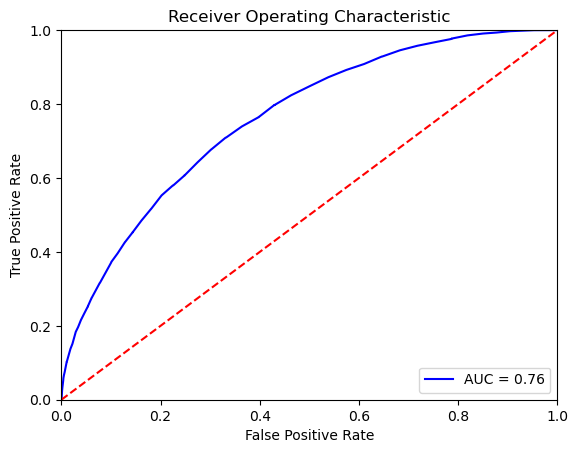

In [50]:
rf_untuned_gl = train_randomforest(X_train_gl, y_train_gl)
evaluate_model(rf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_untuned_gl, "RandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 81.81%
------------------------------------------------
Confusion Matrix:
       0   1
0  20429   3
1   4543  17
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     20432
           1       0.85      0.00      0.01      4560

    accuracy                           0.82     24992
   macro avg       0.83      0.50      0.45     24992
weighted avg       0.82      0.82      0.74     24992



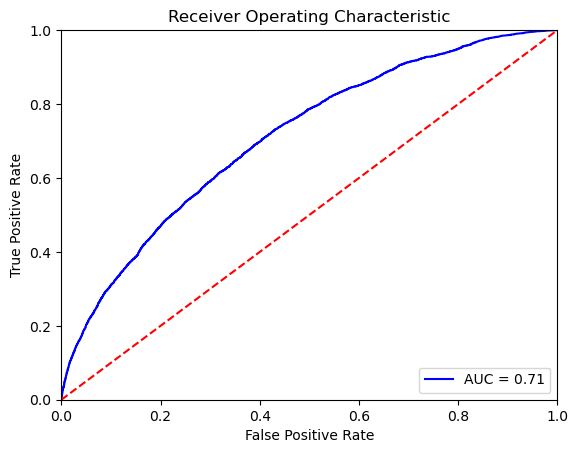

In [51]:
rf_rand_gl = train_randomforest_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(rf_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_rand_gl, "RandomForest", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 82.60%
------------------------------------------------
Confusion Matrix:
       0    1
0  20328  104
1   4244  316
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     20432
           1       0.75      0.07      0.13      4560

    accuracy                           0.83     24992
   macro avg       0.79      0.53      0.52     24992
weighted avg       0.81      0.83      0.76     24992



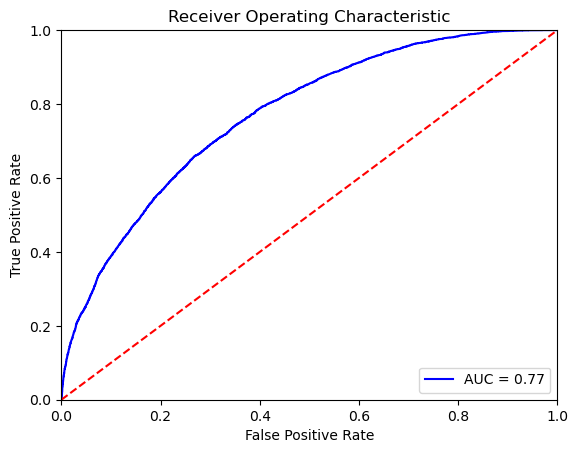

In [52]:
rf_optuna_gl = train_randomforest_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(rf_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_optuna_gl, "RandomForest", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 70.84%
------------------------------------------------
Confusion Matrix:
       0     1
0  14384  6048
1   1240  3320
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.70      0.80     20432
           1       0.35      0.73      0.48      4560

    accuracy                           0.71     24992
   macro avg       0.64      0.72      0.64     24992
weighted avg       0.82      0.71      0.74     24992



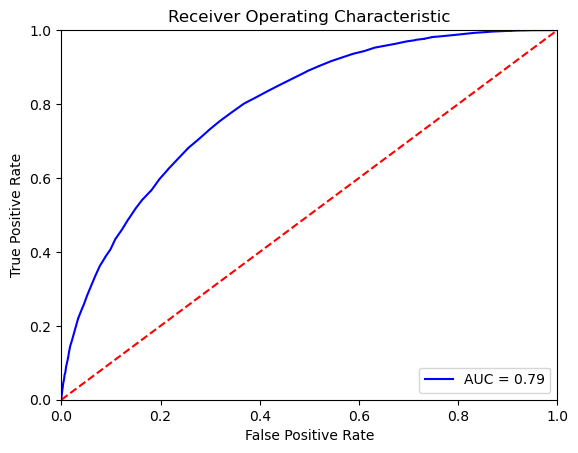

In [53]:
brf_untuned_gl = train_balancedrandomforest(X_train_gl, y_train_gl)
evaluate_model(brf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(brf_untuned_gl, "BalancedRandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 82.78%
------------------------------------------------
Confusion Matrix:
       0     1
0  19590   842
1   3462  1098
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     20432
           1       0.57      0.24      0.34      4560

    accuracy                           0.83     24992
   macro avg       0.71      0.60      0.62     24992
weighted avg       0.80      0.83      0.80     24992



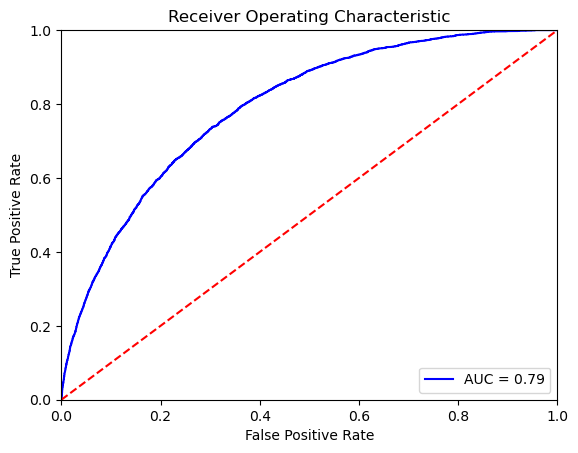

In [54]:
xgb_untuned_gl = train_xgboost(X_train_gl, y_train_gl)
evaluate_model(xgb_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_untuned_gl, "XGBoost", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 83.26%
------------------------------------------------
Confusion Matrix:
       0    1
0  19907  525
1   3659  901
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     20432
           1       0.63      0.20      0.30      4560

    accuracy                           0.83     24992
   macro avg       0.74      0.59      0.60     24992
weighted avg       0.81      0.83      0.79     24992



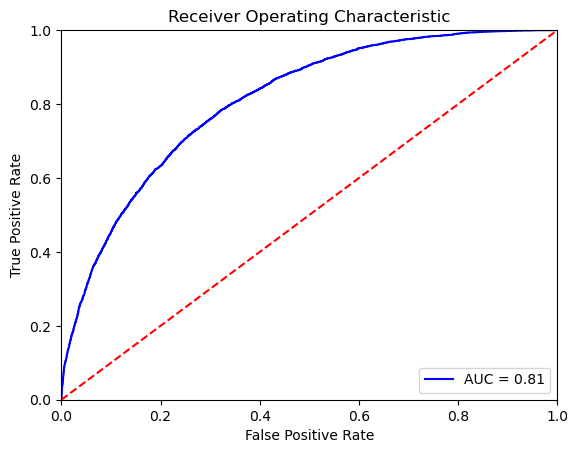

In [55]:
xgb_grid_gl = train_xgboost_tuned_gridsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_grid_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_grid_gl, "XGBoost", "gridsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 83.35%
------------------------------------------------
Confusion Matrix:
       0     1
0  19782   650
1   3511  1049
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90     20432
           1       0.62      0.23      0.34      4560

    accuracy                           0.83     24992
   macro avg       0.73      0.60      0.62     24992
weighted avg       0.81      0.83      0.80     24992



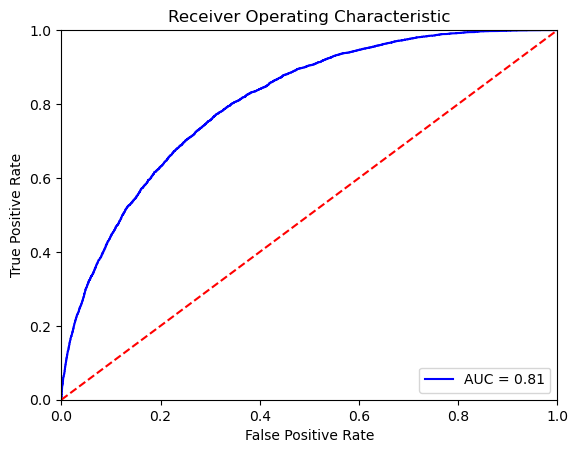

In [56]:
xgb_rand_gl = train_xgboost_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_rand_gl, "XGBoost", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:54] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 82.13%
------------------------------------------------
Confusion Matrix:
       0     1
0  19326  1106
1   3361  1199
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     20432
           1       0.52      0.26      0.35      4560

    accuracy                           0.82     24992
   macro avg       0.69      0.60      0.62     24992
weighted avg       0.79      0.82      0.80     24992



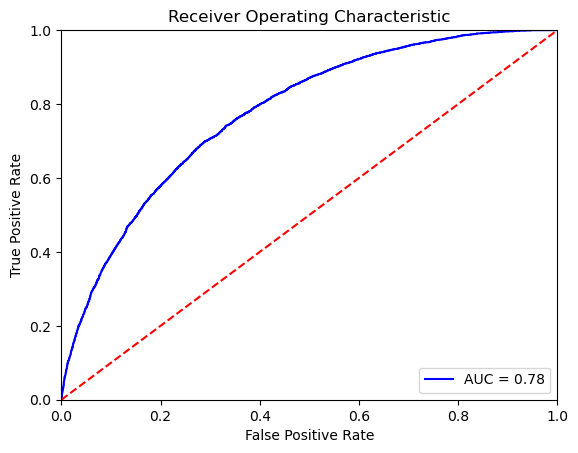

In [57]:
xgb_optuna_gl = train_xgboost_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(xgb_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_optuna_gl, "XGBoost", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

0:	learn: 0.6397639	total: 28ms	remaining: 2.77s
1:	learn: 0.5980550	total: 54.7ms	remaining: 2.68s
2:	learn: 0.5638700	total: 79.5ms	remaining: 2.57s
3:	learn: 0.5363739	total: 105ms	remaining: 2.52s
4:	learn: 0.5160939	total: 131ms	remaining: 2.5s
5:	learn: 0.4979284	total: 160ms	remaining: 2.51s
6:	learn: 0.4840634	total: 187ms	remaining: 2.48s
7:	learn: 0.4728340	total: 214ms	remaining: 2.46s
8:	learn: 0.4636098	total: 241ms	remaining: 2.43s
9:	learn: 0.4551533	total: 269ms	remaining: 2.42s
10:	learn: 0.4481809	total: 298ms	remaining: 2.41s
11:	learn: 0.4432664	total: 325ms	remaining: 2.38s
12:	learn: 0.4386864	total: 352ms	remaining: 2.35s
13:	learn: 0.4350188	total: 379ms	remaining: 2.33s
14:	learn: 0.4317860	total: 406ms	remaining: 2.3s
15:	learn: 0.4291192	total: 431ms	remaining: 2.26s
16:	learn: 0.4267734	total: 459ms	remaining: 2.24s
17:	learn: 0.4244627	total: 486ms	remaining: 2.21s
18:	learn: 0.4224418	total: 514ms	remaining: 2.19s
19:	learn: 0.4203972	total: 541ms	remainin

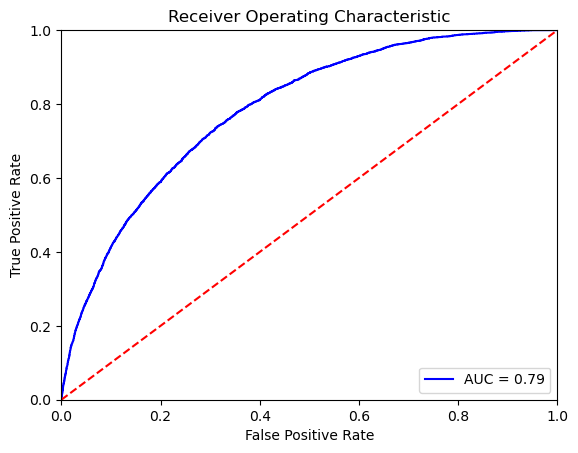

In [58]:
cat_untuned_gl = train_catboost(X_train_gl, y_train_gl)
evaluate_model(cat_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(cat_untuned_gl, "CatBoostClassifier", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

[LightGBM] [Info] Number of positive: 10379, number of negative: 47934
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 58313, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177988 -> initscore=-1.530041
[LightGBM] [Info] Start training from score -1.530041
model accuracy for classification is = 83.23%
------------------------------------------------
Confusion Matrix:
       0    1
0  19985  447
1   3744  816
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     20432
           1       0.65      0.18      0.28      4560

    accuracy                           0.83     24992
   macro avg       0.74      0.58      0.59     24992
weigh

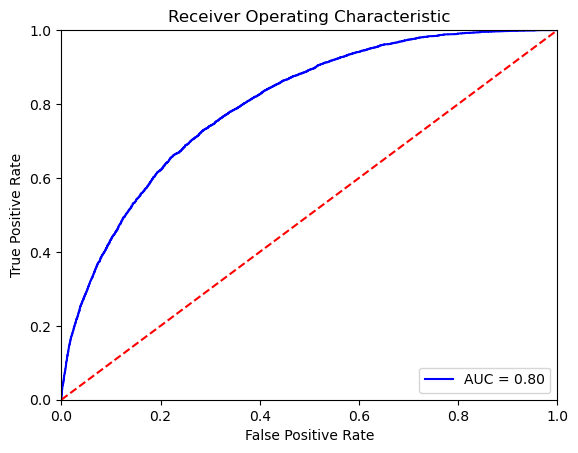

In [59]:
light_untuned_gl = train_lightgbm(X_train_gl, y_train_gl)
evaluate_model(light_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(light_untuned_gl, "LightGBM", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 82.54%
------------------------------------------------
Confusion Matrix:
       0    1
0  19872  560
1   3803  757
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     20432
           1       0.57      0.17      0.26      4560

    accuracy                           0.83     24992
   macro avg       0.71      0.57      0.58     24992
weighted avg       0.79      0.83      0.78     24992



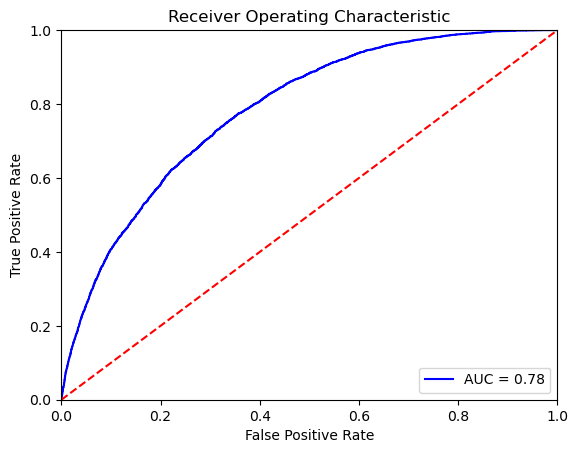

In [60]:
stack_untuned_gl = train_stacking_rf_svm(X_train_gl, y_train_gl)
evaluate_model(stack_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(stack_untuned_gl, "StackingClassifier-RF-SVC", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl,
               y_test_gl)

In [61]:
svc_untuned_gl = train_svc(X_train_gl, y_train_gl)
add_to_eval_df(svc_untuned_gl, "SVC", "untuned", "glove200d", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Model Evaluation

In [62]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,tuning,vec_variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
15,BalancedRandomForest,untuned,tf,0.882959,0.603290,1.000000,0.752565,0.733755,0.384233,0.762061,0.510879
27,BalancedRandomForest,untuned,glove,0.873167,0.583957,0.999518,0.737209,0.708387,0.354398,0.728070,0.476738
3,BalancedRandomForest,untuned,w2v,0.874985,0.587413,1.000000,0.740088,0.690701,0.340222,0.740132,0.466160
22,StackingClassifier-RF-SVC,untuned,tf,0.997188,0.989646,0.994604,0.992119,0.852353,0.685106,0.353070,0.465991
23,SVC,untuned,tf,0.924425,0.895811,0.651122,0.754115,0.845671,0.632792,0.367325,0.464826
17,XGBoost,gridsearch,tf,0.891396,0.912857,0.430966,0.585510,0.854233,0.726196,0.322807,0.446941
19,XGBoost,optuna,tf,0.870801,0.799916,0.365546,0.501785,0.849352,0.688657,0.318202,0.435278
16,XGBoost,untuned,tf,0.876563,0.872221,0.359090,0.508736,0.853393,0.743214,0.300219,0.427679
21,LightGBM,untuned,tf,0.868125,0.814209,0.335678,0.475372,0.851152,0.727273,0.294737,0.419476
18,XGBoost,randsearch,tf,0.865776,0.832465,0.307833,0.449462,0.850792,0.748060,0.274781,0.401925


In [63]:
evaluation.to_csv("eval/evaluation_mixeddata_rnn.csv")